# Using `imputation_utils` functions from the `jmspack` package

## Showing the usage of the following `imputation_utils` functions

- RMSE()
- mice_forest()
- mice_forest_tune()
- groupby_mice()
- simple_impute()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os

In [2]:
tmp = os.getcwd()
os.chdir(tmp.split("jmspack")[0] + "jmspack")
from jmspack.imputation_utils import (
                              RMSE,
                              mice_forest,
                              mice_forest_tune,
                              groupby_mice,
                              simple_impute
                          )

from jmspack.utils import JmsColors, apply_scaling
from jmspack.frequentist_statistics import correlation_analysis
os.chdir(tmp)

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [4]:
if "jms_style_sheet" in plt.style.available:
    _ = plt.style.use("jms_style_sheet")

In [5]:
X, y, coefs = make_regression(n_samples=100, n_features=10, coef=True)
pd.DataFrame(coefs).T

,0,1,2,3,4,5,6,7,8,9
0,46.52999,14.168002,83.395475,38.226114,31.998491,16.711863,42.769433,69.875444,61.974311,96.825477


In [6]:
df = pd.DataFrame(X, columns=[f"p{x}" for x in range(X.shape[1])]).assign(**{"target": y,
                                                                             "user_id": np.repeat(np.arange(10), repeats=10),
                                                                             "date": pd.date_range("04-04-2021", "10-12-2021")[0:100]})
miss_df = df.copy()

In [7]:
feature_list = df.filter(regex="p").columns.tolist()

In [8]:
np.random.seed(42)
miss_df[feature_list] = miss_df[feature_list].mask(np.random.choice([True, False], size=1000, p=[0.8, 0.2]).reshape(100, 10))
miss_df=miss_df.rename(columns=dict(zip(feature_list, [f"{x}_w_miss" for x in feature_list])))

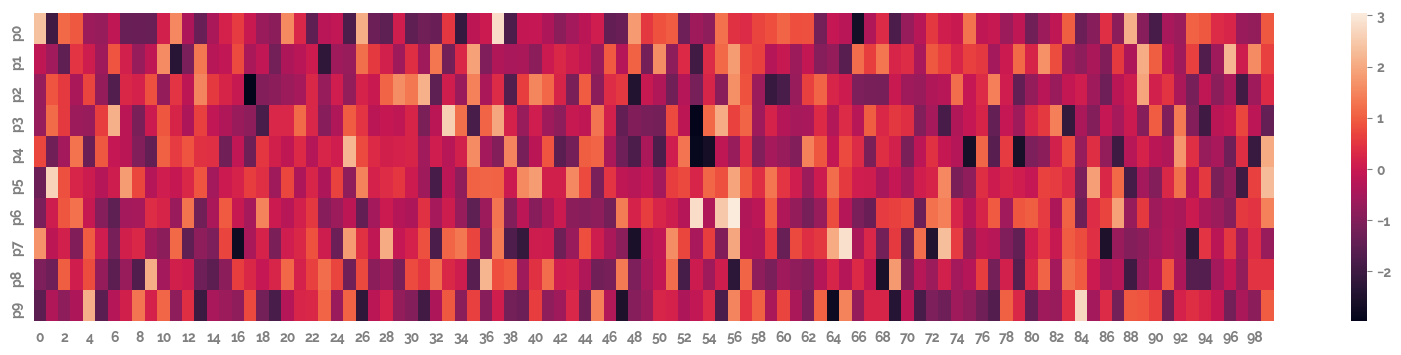

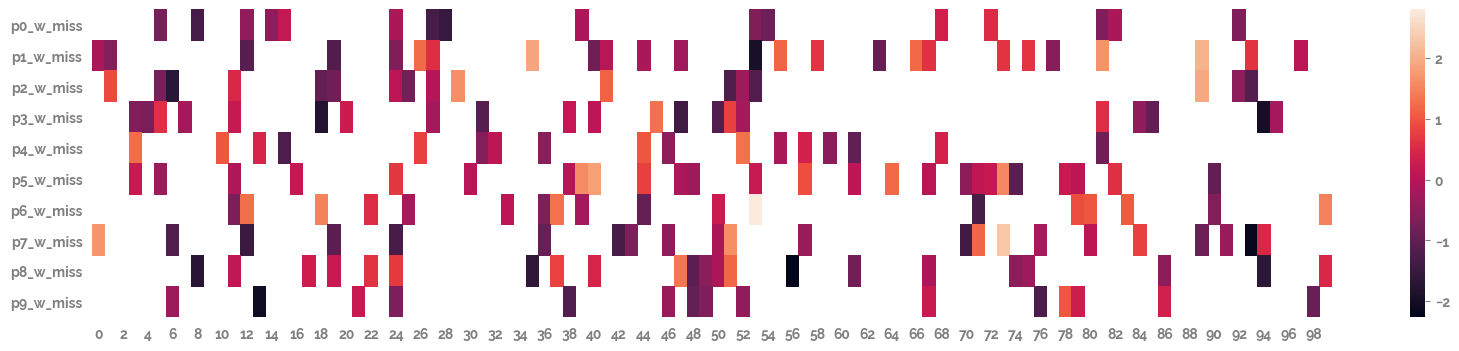

In [9]:
_ = plt.figure(figsize=(20, 4))
_ = sns.heatmap(data=df[feature_list].T)
_ = plt.figure(figsize=(20, 4))
_ = sns.heatmap(data=miss_df[[f"{x}_w_miss" for x in feature_list]].T)

In [10]:
feature = feature_list[0]
id_column = "user_id"
date_column = "date"

In [11]:
assign_dict = {feature: df[feature],
               f"{feature}_mean": lambda d: d[f"{feature}_w_miss"].pipe(simple_impute, strategy="mean"),
               f"{feature}_median": lambda d: d[f"{feature}_w_miss"].pipe(simple_impute, strategy="median"),
               # f"{feature}_mice_groupby": lambda d: groupby_mice(data=d, ids=d[id_column].unique().tolist())[f"{feature}_w_miss"].values,
                  f"{feature}_mice": lambda d: mice_forest(data=d.set_index([id_column, date_column]))[f"{feature}_w_miss"].values,
                  f"{feature}_linear_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method="linear"),
                  f"{feature}_time_interpolate": lambda d: d.set_index(date_column)[[f"{feature}_w_miss"]].interpolate(method="time").values,
                  f"{feature}_nearest_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method="nearest"),
                  # f"{feature}_poly_5_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method='polynomial', order=5),
                  f"{feature}_spline_5_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method='spline', order=5),
                  }

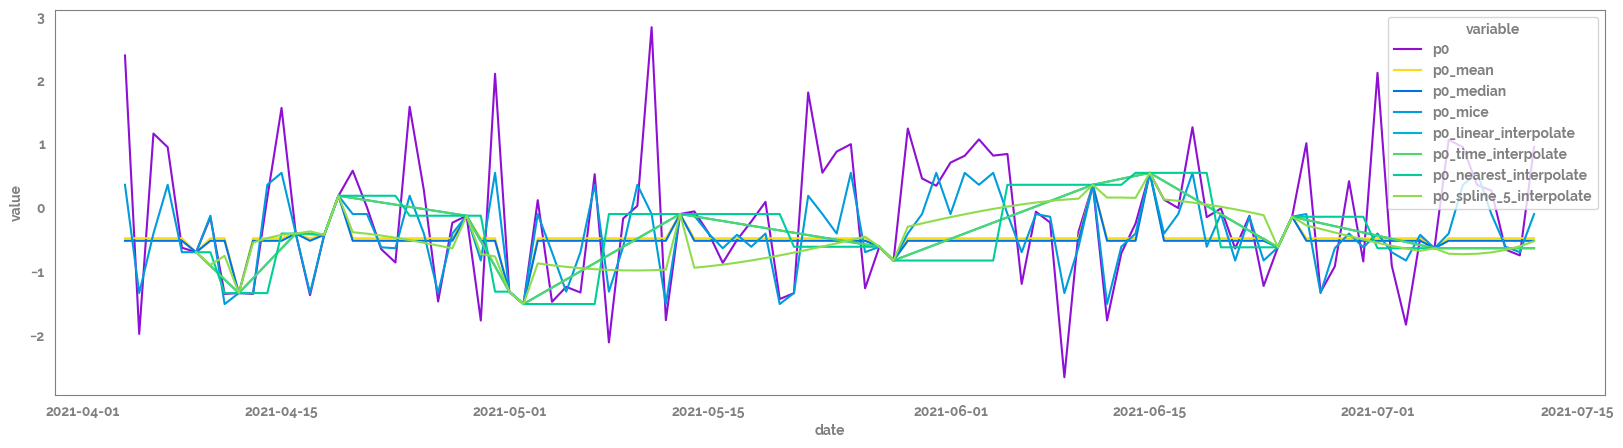

In [12]:
_ = plt.figure(figsize=(20,5))
plot_df = (miss_df
                [[f"{feature}_w_miss", id_column, date_column]]
                 .assign(**assign_dict)
                .drop(f"{feature}_w_miss", axis=1)
                 .melt(id_vars = [id_column, date_column]))
_ = sns.lineplot(data=plot_df, x=date_column, y="value", hue="variable")

In [13]:
comp_df = (miss_df[[f"{feature}_w_miss", id_column, date_column]]
                .assign(**assign_dict)
                .filter(regex=feature)
                .pipe(apply_scaling)
                .drop(f"{feature}_w_miss", axis=1)
                .dropna()
                )
rmse_df = pd.concat([pd.DataFrame({f"{feature}": RMSE(comp_df[feature], comp_df[y])}, index=[y]) for y in comp_df.drop(feature, axis=1)])
comp_df.head()

,p0,p0_mean,p0_median,p0_mice,p0_linear_interpolate,p0_time_interpolate,p0_nearest_interpolate,p0_spline_5_interpolate
5,0.357183,0.395085,0.395085,0.395085,0.395085,0.395085,0.395085,0.395085
6,0.457002,0.501464,0.482303,0.673273,0.291220,0.291220,0.395085,0.298811
7,0.238051,0.501464,0.482303,0.000000,0.187355,0.187355,0.083490,0.367580
8,0.240395,0.083490,0.083490,0.083490,0.083490,0.083490,0.083490,0.083490
9,0.238101,0.501464,0.482303,0.083490,0.196967,0.196967,0.083490,0.468217


In [14]:
colors = [JmsColors.YELLOW, "#F7F1F0", JmsColors.PURPLE]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'heatmap_cmap'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bins)

feat_list = list(assign_dict.keys())
corr_df = correlation_analysis(data=comp_df, col_list=[feat_list[0]], row_list=feat_list[1:], method="spearman")["summary"]
corr_df.style.background_gradient(cmap=cm,
                                  subset="r-value",
                                  vmin=0,
                                  vmax=1,
                                  axis=0).format({'r-value':'{:.4f}', 'p-value':'{:.3f}'})

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,p0,p0_mean,0.2485,0.020,True,88
1,Spearman Rank,p0,p0_median,0.2485,0.020,True,88
2,Spearman Rank,p0,p0_mice,0.9050,0.000,True,88
3,Spearman Rank,p0,p0_linear_interpolate,0.1572,0.144,False,88
4,Spearman Rank,p0,p0_time_interpolate,0.1572,0.144,False,88
5,Spearman Rank,p0,p0_nearest_interpolate,0.0478,0.658,False,88
6,Spearman Rank,p0,p0_spline_5_interpolate,0.2591,0.015,True,88


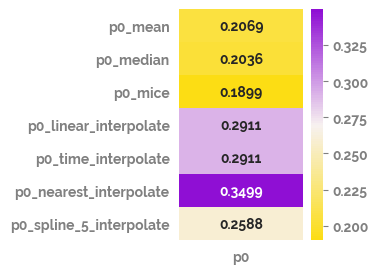

In [15]:
_ = plt.figure(figsize=(2,3))
_ = sns.heatmap(data=rmse_df,
                annot=True,
                fmt=".4g",
                cmap=cm)
_ = plt.yticks(rotation=0)

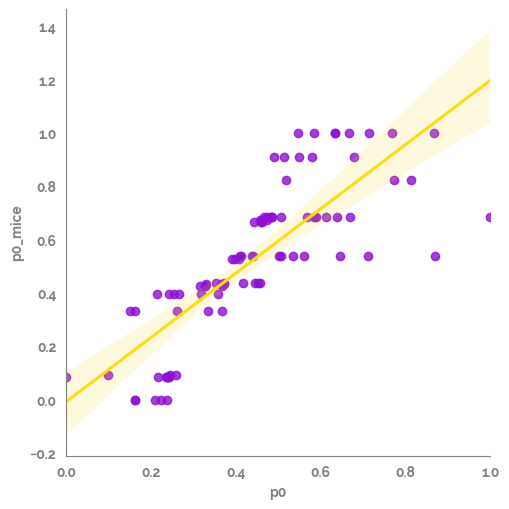

In [16]:
_ = sns.lmplot(data=comp_df,
               x=feature,
               y=f"{feature}_mice",
               line_kws={"color":JmsColors.YELLOW}
               )

0.020801599955983407


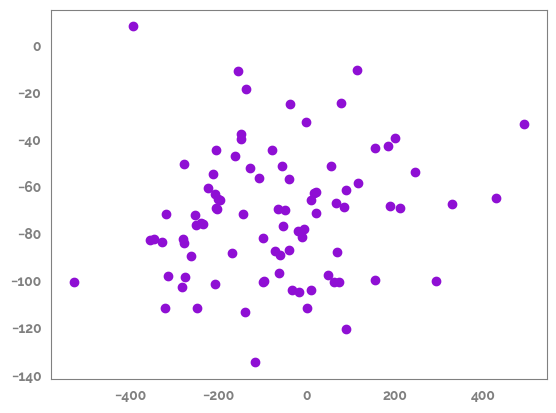

In [17]:
mod = LinearRegression()
_ = mod.fit(X=comp_df[[feature]], y=df.loc[6:93, "target"])
y_pred = mod.predict(X=comp_df[[feature]])
print(r2_score(y_true=df.loc[6:93, "target"], y_pred=y_pred))
_ = plt.scatter(df.loc[6:93, "target"], y_pred)

0.03209983328274635


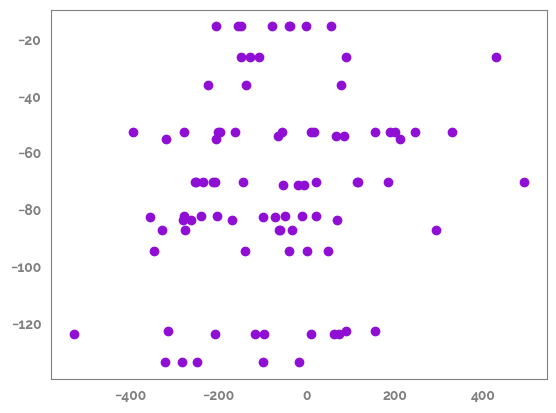

In [18]:
mod = LinearRegression()
_ = mod.fit(X=comp_df[[f"{feature}_mice"]], y=df.loc[6:93, "target"])
y_pred = mod.predict(X=comp_df[[f"{feature}_mice"]])
print(r2_score(y_true=df.loc[6:93, "target"], y_pred=y_pred))
_ = plt.scatter(df.loc[6:93, "target"], y_pred)